 ## Step 1 - Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import lightning as pl
from simplelogger import SimpleLogger
from pathlib import Path

data_path = Path().cwd().parent / "data"

In [7]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128
print(f"lightning version -> {pl.__version__}")  # 2.5.5

Python version -> 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
torch version -> 2.8.0+cu128
lightning version -> 2.5.5


 ## Step 2 - Load and Prepare Data

In [ ]:
data = pd.read_csv(data_path / "heart.csv", sep=";")

x = data[
    ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
].values.astype(np.float32)
y = data[["HeartDisease"]].values.astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=123
)

# Convert to torch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

print("Train data:", x_train_tensor.shape)
print("Test data :", x_test_tensor.shape)

Train data: torch.Size([734, 6])
Test data : torch.Size([184, 6])


 ## Step 3 - Define the Model

In [41]:
class HeartDiseaseModel(pl.LightningModule):
    def __init__(self, input_dim, lr=1e-3):
        super(HeartDiseaseModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 4)
        self.layer2 = nn.Linear(4, 4)
        self.output = nn.Linear(4, 1)
        self.relu = nn.ReLU()
        self.criterion = nn.BCELoss()
        self.sigmoid = nn.Sigmoid()
        self.lr = lr

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

    def training_step(self, batch, batch_idx):
        x, target = batch
        pred = self.forward(x)
        loss = self.criterion(pred, target)
        acc = ((pred > 0.5).float() == target).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", value=acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, target = batch
        pred = self.forward(x)
        loss = self.criterion(pred, target)
        acc = ((pred > 0.5).float() == target).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]


input_dim = x_train.shape[1]
model = HeartDiseaseModel(input_dim, lr=1e-4)
print(model)

HeartDiseaseModel(
  (layer1): Linear(in_features=6, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (criterion): BCELoss()
  (sigmoid): Sigmoid()
)


 ## Step 4 - Compile and Train

In [42]:
trainer = pl.Trainer(
    max_epochs=200,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    check_val_every_n_epoch=1,
)
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | layer1    | Linear  | 28     | train
1 | layer2    | Linear  | 20     | train
2 | output    | Linear  | 5      | train
3 | relu      | ReLU    | 0      | train
4 | criterion | BCELoss | 0      | train
5 | sigmoid   | Sigmoid | 0      | train
----------------------------------------------
53        Trainable params
0         Non-trainable params
53        Total params
0.000     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 199: 100%|██████████| 37/37 [00:00<00:00, 310.24it/s, v_num=0.1, val_loss=0.633, train_loss=0.588]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 37/37 [00:00<00:00, 308.60it/s, v_num=0.1, val_loss=0.633, train_loss=0.588]


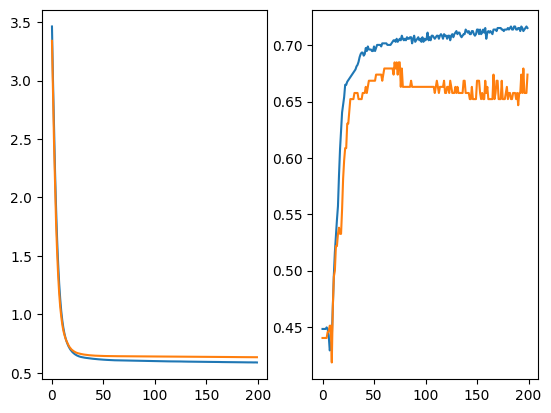

 ## Step 5 - Evaluate

In [44]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test_tensor)
    y_pred_class = (y_pred > 0.5).float()

test_loss = model.criterion(y_pred, y_test_tensor).item()
test_acc = (y_pred_class == y_test_tensor).float().mean().item()

print(f"Test loss     : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")

Test loss     : 0.6329
Test accuracy : 0.6739


 ## Step 6 - Visualization

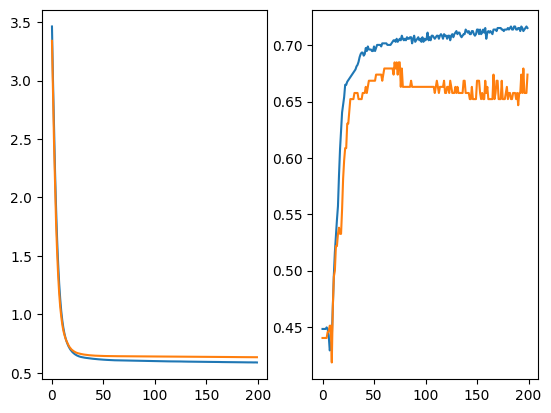

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(trainer.logger.metrics["train_loss"], label="train")
plt.plot(trainer.logger.metrics["val_loss"], label="test")
plt.subplot(1, 2, 2)
plt.plot(trainer.logger.metrics["train_acc"], label="train")
plt.plot(trainer.logger.metrics["val_acc"], label="test")

 ## Step 7 - Metrics

In [46]:
y_true = y_test_tensor.numpy().flatten()
y_pred_np = y_pred_class.numpy().flatten()

print(confusion_matrix(y_true, y_pred_np))
print(classification_report(y_true, y_pred_np))

[[54 27]
 [33 70]]
              precision    recall  f1-score   support

         0.0       0.62      0.67      0.64        81
         1.0       0.72      0.68      0.70       103

    accuracy                           0.67       184
   macro avg       0.67      0.67      0.67       184
weighted avg       0.68      0.67      0.67       184



In [47]:
# Example of manual metrics calculation:
precision = 83 / (28 + 83)
accuracy = (83 + 53) / (53 + 28 + 83 + 20)
precision, accuracy

(0.7477477477477478, 0.7391304347826086)